In [4]:
# Import libraries
import pickle
import requests
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch

load_dotenv()
key = os.getenv('API_KEY')
api_url = "http://api.positionstack.com/v1/forward"

def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = "Serangoon"
df = df[(df.town==town.upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 1773


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129302,SERANGOON,3 ROOM,5,LOR LEW LIAN,64.0,Improved,1978,55 years,390000.0,8.0,65.0
129303,SERANGOON,3 ROOM,303,SERANGOON AVE 2,69.0,Improved,1984,61 years 07 months,450000.0,5.0,65.0
129304,SERANGOON,3 ROOM,220,SERANGOON AVE 4,67.0,New Generation,1984,61 years 07 months,380000.0,8.0,65.0
129305,SERANGOON,3 ROOM,203,SERANGOON CTRL,64.0,Simplified,1986,62 years 08 months,438000.0,5.0,65.0
129306,SERANGOON,3 ROOM,106,SERANGOON NTH AVE 1,69.0,Improved,1984,61 years 03 months,368000.0,8.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153614,SERANGOON,4 ROOM,521,SERANGOON NTH AVE 4,106.0,Model A,1992,68 years 06 months,530000.0,5.0,76.0
153615,SERANGOON,5 ROOM,121,SERANGOON NTH AVE 1,123.0,Improved,1985,61 years 03 months,648000.0,8.0,76.0
153616,SERANGOON,5 ROOM,502,SERANGOON NTH AVE 4,125.0,Improved,1992,68 years 07 months,688000.0,8.0,76.0
153617,SERANGOON,5 ROOM,507,SERANGOON NTH AVE 4,120.0,Improved,1997,73 years,650000.0,2.0,76.0


In [5]:
blk_street = df.block + ' ' + df.street_name

responses = []
count = 0
for i,add in enumerate(blk_street.unique()):
  response = requests.get(f"{api_url}?access_key={key}&query={add}+singapore")
  responses.append(response.json())
  first_response = response.json()['data'][0]
  if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
    longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
    if (i%10==0):
      print(f"{i} of {len(blk_street.unique())}")
  else:
    print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
    count += 1

pickle.dump(longLats, open('./longLat.pkl', 'wb'))
print(f"{count} errors")


check 5 LOR LEW LIAN. Singapore. confidence of 0.6
10 of 186
20 of 186
check 1 LOR LEW LIAN. Singapore. confidence of 0.6
check 2 LOR LEW LIAN. Singapore. confidence of 0.6
30 of 186
40 of 186
50 of 186
60 of 186
70 of 186
80 of 186
90 of 186
100 of 186
check 8 LOR LEW LIAN. Singapore. confidence of 0.6
110 of 186
120 of 186
check 4 LOR LEW LIAN. Singapore. confidence of 0.6
check 7 LOR LEW LIAN. Singapore. confidence of 0.6
check 6 LOR LEW LIAN. Singapore. confidence of 0.6
140 of 186
150 of 186
160 of 186
170 of 186
180 of 186


1952

In [6]:
errors = [
  "1 LOR LEW LIAN",
  "2 LOR LEW LIAN",
  "4 LOR LEW LIAN",
  "5 LOR LEW LIAN",
  "6 LOR LEW LIAN",
  "7 LOR LEW LIAN",
  "8 LOR LEW LIAN",
]
len(errors)

7

In [7]:
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129302,SERANGOON,3 ROOM,5,LOR LEW LIAN,64.0,Improved,1978,55 years,390000.0,8.0,65.0
129303,SERANGOON,3 ROOM,303,SERANGOON AVE 2,69.0,Improved,1984,61 years 07 months,450000.0,5.0,65.0
129304,SERANGOON,3 ROOM,220,SERANGOON AVE 4,67.0,New Generation,1984,61 years 07 months,380000.0,8.0,65.0
129305,SERANGOON,3 ROOM,203,SERANGOON CTRL,64.0,Simplified,1986,62 years 08 months,438000.0,5.0,65.0
129306,SERANGOON,3 ROOM,106,SERANGOON NTH AVE 1,69.0,Improved,1984,61 years 03 months,368000.0,8.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153614,SERANGOON,4 ROOM,521,SERANGOON NTH AVE 4,106.0,Model A,1992,68 years 06 months,530000.0,5.0,76.0
153615,SERANGOON,5 ROOM,121,SERANGOON NTH AVE 1,123.0,Improved,1985,61 years 03 months,648000.0,8.0,76.0
153616,SERANGOON,5 ROOM,502,SERANGOON NTH AVE 4,125.0,Improved,1992,68 years 07 months,688000.0,8.0,76.0
153617,SERANGOON,5 ROOM,507,SERANGOON NTH AVE 4,120.0,Improved,1997,73 years,650000.0,2.0,76.0


In [8]:
dfL = df[(~df.street_name.str.startswith('LOR LEW LIAN'))]
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
dfL.to_csv(file,index=False)
dfL

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129303,SERANGOON,3 ROOM,303,SERANGOON AVE 2,69.0,Improved,1984,61 years 07 months,450000.0,5.0,65.0
129304,SERANGOON,3 ROOM,220,SERANGOON AVE 4,67.0,New Generation,1984,61 years 07 months,380000.0,8.0,65.0
129305,SERANGOON,3 ROOM,203,SERANGOON CTRL,64.0,Simplified,1986,62 years 08 months,438000.0,5.0,65.0
129306,SERANGOON,3 ROOM,106,SERANGOON NTH AVE 1,69.0,Improved,1984,61 years 03 months,368000.0,8.0,65.0
129307,SERANGOON,4 ROOM,405,SERANGOON AVE 1,113.0,Model A,1989,65 years 08 months,739888.0,11.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153614,SERANGOON,4 ROOM,521,SERANGOON NTH AVE 4,106.0,Model A,1992,68 years 06 months,530000.0,5.0,76.0
153615,SERANGOON,5 ROOM,121,SERANGOON NTH AVE 1,123.0,Improved,1985,61 years 03 months,648000.0,8.0,76.0
153616,SERANGOON,5 ROOM,502,SERANGOON NTH AVE 4,125.0,Improved,1992,68 years 07 months,688000.0,8.0,76.0
153617,SERANGOON,5 ROOM,507,SERANGOON NTH AVE 4,120.0,Improved,1997,73 years,650000.0,2.0,76.0


In [10]:
df[(df.street_name.str.startswith('LOR LEW LIAN'))].describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date
count,23.000000,23.000000,23.000000,23.000000,23.000000
mean,69.347826,1978.869565,393217.391304,6.304348,70.565217
std,15.089457,1.937767,66322.871773,4.321561,3.341558
min,44.000000,1978.000000,263000.000000,2.000000,65.000000
25%,64.000000,1978.000000,362500.000000,2.000000,68.500000
50%,64.000000,1978.000000,380000.000000,5.000000,71.000000
75%,73.000000,1978.000000,405000.000000,9.500000,73.000000
max,98.000000,1983.000000,526000.000000,14.000000,76.000000


In [12]:
df = pd.read_csv(f'./data/{town}_June22_May23_without_newest.csv')
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
0,SERANGOON,3 ROOM,303,SERANGOON AVE 2,69.0,Improved,1984,61 years 07 months,450000.0,5.0,65.0
1,SERANGOON,3 ROOM,220,SERANGOON AVE 4,67.0,New Generation,1984,61 years 07 months,380000.0,8.0,65.0
2,SERANGOON,3 ROOM,203,SERANGOON CTRL,64.0,Simplified,1986,62 years 08 months,438000.0,5.0,65.0
3,SERANGOON,3 ROOM,106,SERANGOON NTH AVE 1,69.0,Improved,1984,61 years 03 months,368000.0,8.0,65.0
4,SERANGOON,4 ROOM,405,SERANGOON AVE 1,113.0,Model A,1989,65 years 08 months,739888.0,11.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
381,SERANGOON,4 ROOM,521,SERANGOON NTH AVE 4,106.0,Model A,1992,68 years 06 months,530000.0,5.0,76.0
382,SERANGOON,5 ROOM,121,SERANGOON NTH AVE 1,123.0,Improved,1985,61 years 03 months,648000.0,8.0,76.0
383,SERANGOON,5 ROOM,502,SERANGOON NTH AVE 4,125.0,Improved,1992,68 years 07 months,688000.0,8.0,76.0
384,SERANGOON,5 ROOM,507,SERANGOON NTH AVE 4,120.0,Improved,1997,73 years,650000.0,2.0,76.0


In [13]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,386.000000,386.000000,3.860000e+02,386.000000,386.000000,386.000000,386.000000
mean,100.261658,1988.297927,5.964303e+05,6.484456,70.479275,103.871818,1.360997
std,25.479025,4.408003,1.764212e+05,3.474735,3.369972,0.002558,0.009391
min,60.000000,1984.000000,3.150000e+05,2.000000,65.000000,103.865252,1.346407
25%,84.000000,1985.000000,4.600000e+05,5.000000,68.000000,103.870197,1.353229
50%,100.000000,1986.000000,5.635000e+05,5.000000,70.000000,103.871887,1.357377
75%,121.000000,1992.000000,7.000000e+05,8.000000,74.000000,103.873583,1.370727
max,156.000000,1999.000000,1.130000e+06,17.000000,76.000000,103.876580,1.374978


In [14]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
dls.show_batch()

,floor,floor_area_sqm,lease_commence_date,date,lat,long,resale_price
0,8.0,100.000000,1997.0,76.0,1.372299,103.870796,561000.0
1,8.0,147.000000,1992.0,75.0,1.374027,103.872101,900000.0
2,8.0,119.999999,1997.0,73.0,1.371573,103.875259,725000.0
3,8.0,105.000000,1985.0,73.0,1.354804,103.869530,653000.0
4,14.0,99.000000,1999.0,73.0,1.355131,103.872032,830000.0
5,11.0,83.000000,1987.0,70.0,1.368178,103.872932,438888.0
6,2.0,145.999999,1986.0,73.0,1.367534,103.873825,820000.0
7,5.0,99.000000,1999.0,73.0,1.355174,103.872704,635000.0
8,14.0,93.000000,1985.0,69.0,1.369056,103.870583,465000.0
9,5.0,83.999999,1985.0,68.0,1.351583,103.873596,608000.0


SuggestedLRs(valley=0.0014454397605732083, slide=6.309573450380412e-07)

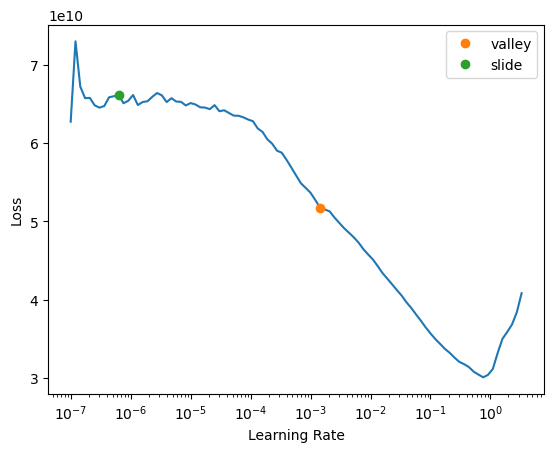

In [15]:
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [23]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 38101.50390625.


(#2) [1452378112.0,38101.50390625]

In [29]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 30576.142578125.


(#2) [979451840.0,30576.142578125]

In [24]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 4*20
n2 = 7*20
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}")
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()

0 of 140
1 of 140
2 of 140
3 of 140
4 of 140
5 of 140
6 of 140
7 of 140
8 of 140
9 of 140
10 of 140
11 of 140
12 of 140
13 of 140
14 of 140
15 of 140
16 of 140
17 of 140
18 of 140
19 of 140
20 of 140
21 of 140
22 of 140
23 of 140
24 of 140
25 of 140
26 of 140
27 of 140
28 of 140
29 of 140
30 of 140
31 of 140
32 of 140
33 of 140
34 of 140
35 of 140
36 of 140
37 of 140
38 of 140
39 of 140
40 of 140
41 of 140
42 of 140
43 of 140
44 of 140
45 of 140
46 of 140
47 of 140
48 of 140
49 of 140
50 of 140
51 of 140
52 of 140
53 of 140
54 of 140
55 of 140
56 of 140
57 of 140
58 of 140
59 of 140
60 of 140
61 of 140
62 of 140
63 of 140
64 of 140
65 of 140
66 of 140
67 of 140
68 of 140
69 of 140
70 of 140
71 of 140
72 of 140
73 of 140
74 of 140
75 of 140
76 of 140
77 of 140
78 of 140
79 of 140
80 of 140
81 of 140
82 of 140
83 of 140
84 of 140
85 of 140
86 of 140
87 of 140
88 of 140
89 of 140
90 of 140
91 of 140
92 of 140
93 of 140
94 of 140
95 of 140
96 of 140
97 of 140
98 of 140
99 of 140
100 of 140

In [25]:
import http.client, urllib.parse
import json

mrts = ["Lorong Chuan MRT", "Serangoon MRT"]

longLats = load_pkl()

responses = []
for mrt in mrts:
    conn = http.client.HTTPConnection('api.positionstack.com')
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': mrt + ' Station',
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    first_response = json.loads(data.decode('utf-8'))['data'][0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
        longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
        print(f"{first_response['label']}, confidence {first_response['confidence']}")
    else:
        print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 1954
Napier MRT Station, Singapore, confidence 1
Serangoon MRT Station, Singapore, confidence 1


NameError: name 'dump_pkl' is not defined

In [26]:
longLats['Lorong Chuan MRT'] = (103.86458,1.3516)

In [27]:
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
dump_pkl(longLats)


pickle dumped. 1956


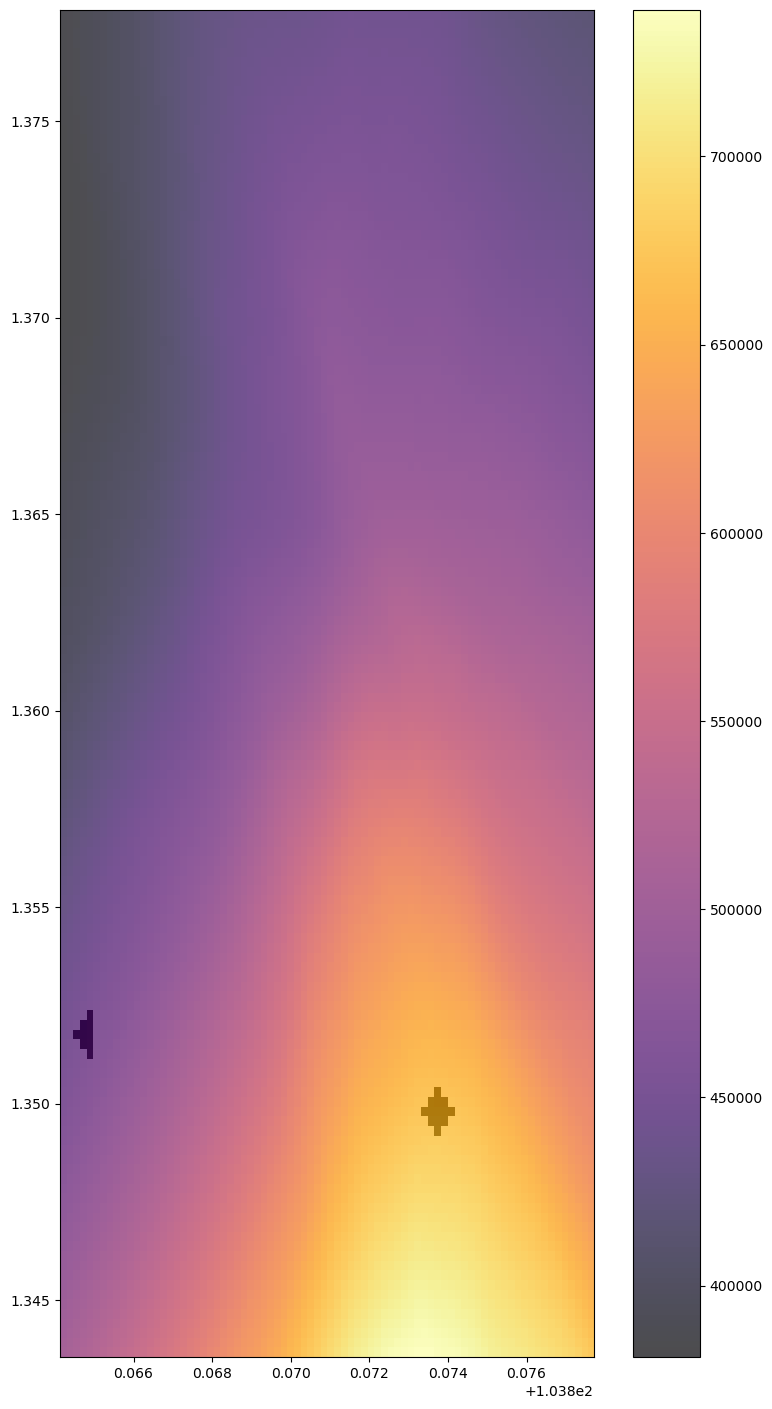

In [30]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
mrt_map = np.zeros((n2,n1))
#mrts = ["Yio Chu Kang MRT", "Ang Mo Kio MRT"]
#for mrt in mrts:
#  (i,j) = min_coords(*longLats[mrt])
#  #for m in range(3):
#  #  for n in range(3):
#  mrt_map[j+m-1][i+n-1] = 1

(i,j) = min_coords(*longLats[mrts[0]])
# left
mrt_map[j-2][i+1]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i+1]=1
mrt_map[j+2][i+1]=1


"""
(i,j) = min_coords(*longLats[mrts[0]])
# up
mrt_map[j+1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j-1][i-2]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i+2]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
# left
mrt_map[j-2][i+1]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i+1]=1
mrt_map[j+2][i+1]=1
# right?
mrt_map[j-2][i-1]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+2][i-1]=1
"""
(i,j) = min_coords(*longLats[mrts[1]])
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i-1]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j][i-2]=1
mrt_map[j][i+2]=1
mrt_map[j+2][i]=1
mrt_map[j-2][i]=1

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

In [50]:
longLeft,longRight

(103.8288214, 103.8619606)

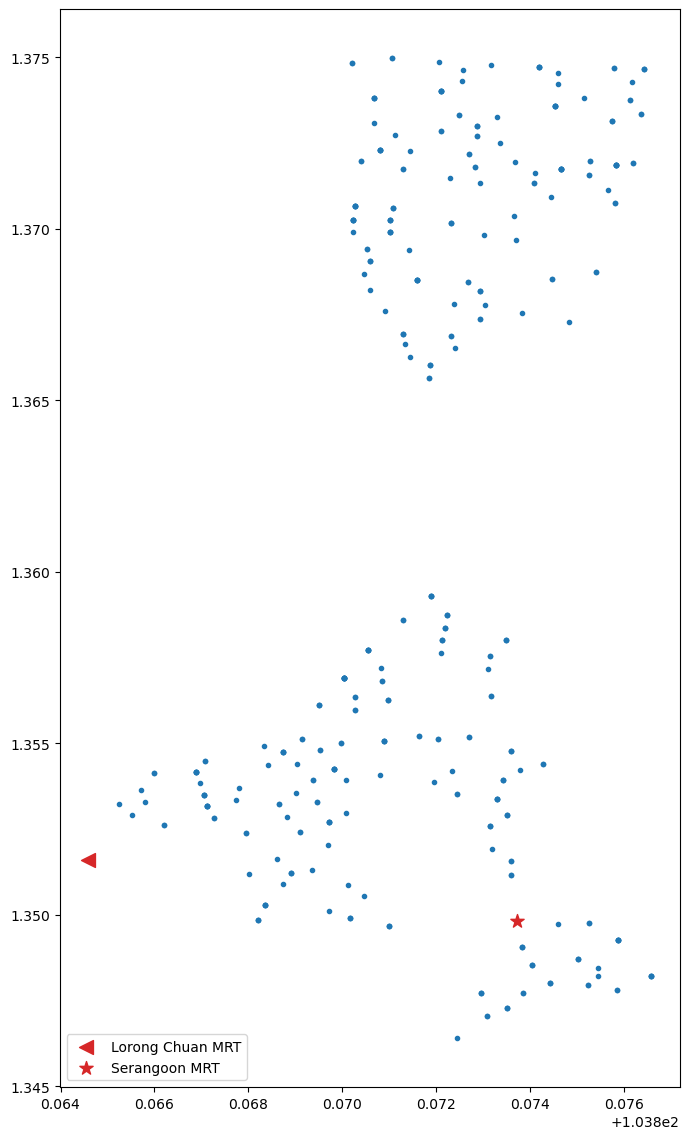

In [31]:
markers = ["<", "*"]

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='lower left')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()


for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
